# Lab 1: Independent Component Analysis

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday September 17th, 16:59.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [386]:
%pylab inline
import sys
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed"

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    figure()
    
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)

Populating the interactive namespace from numpy and matplotlib


The following code generates some toy data to work with.

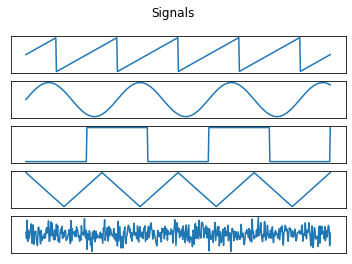

In [387]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$.

In [388]:
### 1.1 Make mixtures
def make_mixtures(S, A):
    # YOUR CODE HERE
    return A@S

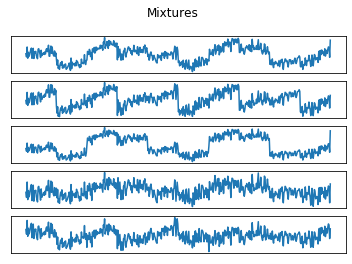

In [389]:
### Test your function
np.random.seed(42)
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X, "Mixtures")

assert X.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the `np.histogram()` (followed by `plot`) or `plt.hist()` function. 

Plot histograms of the sources and the measurements.

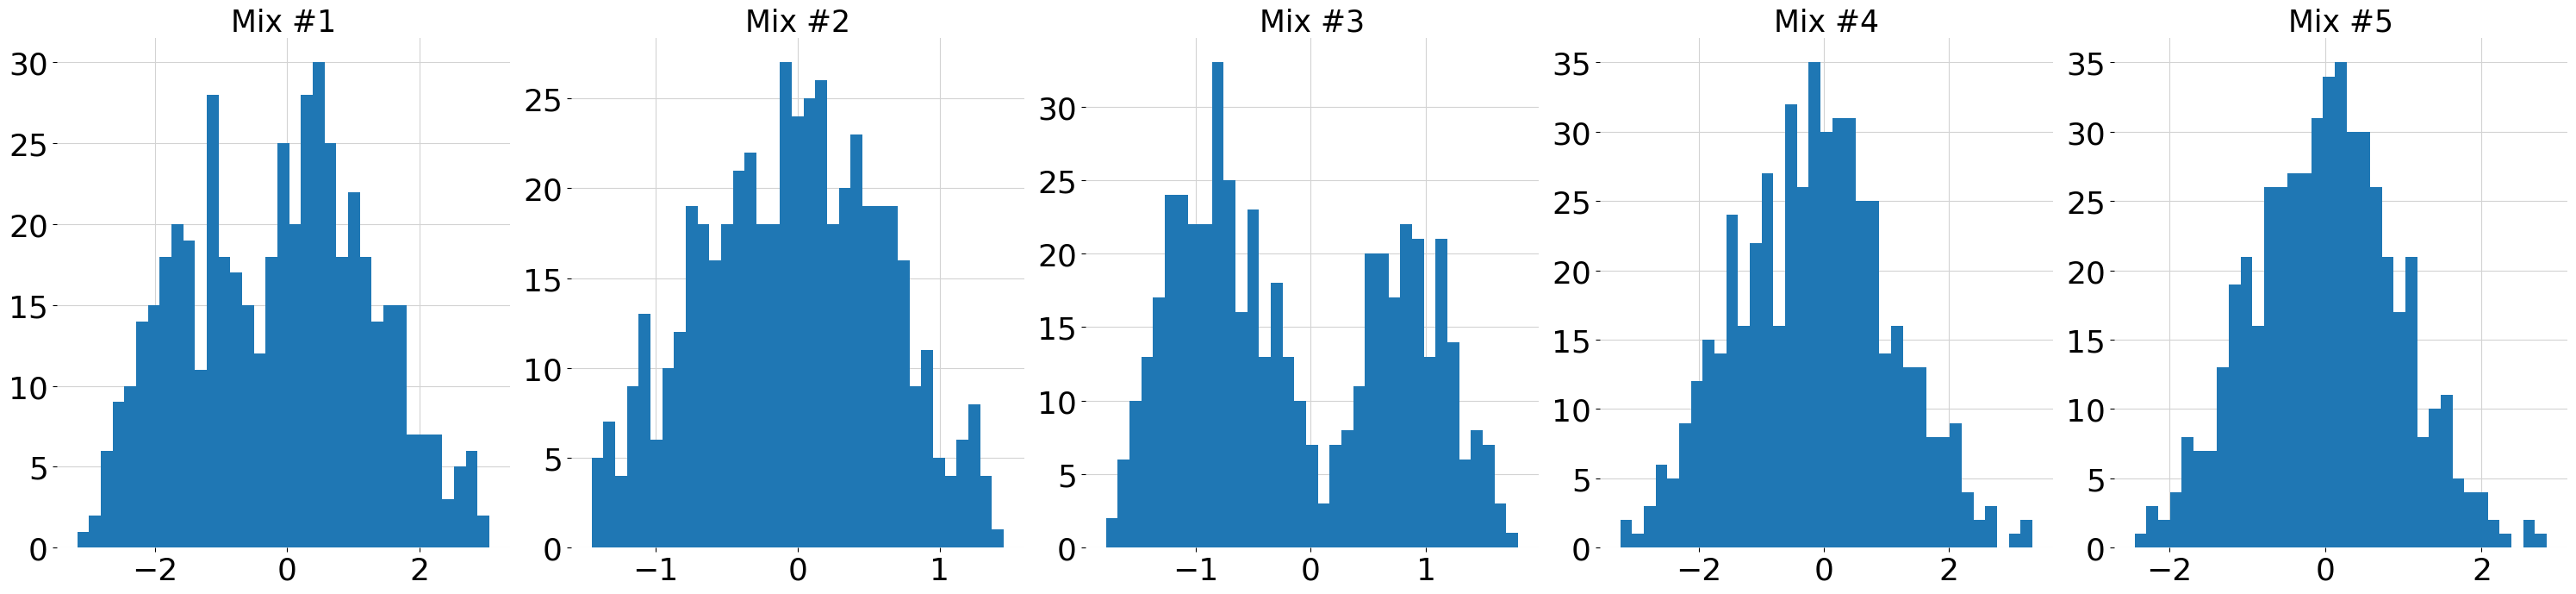

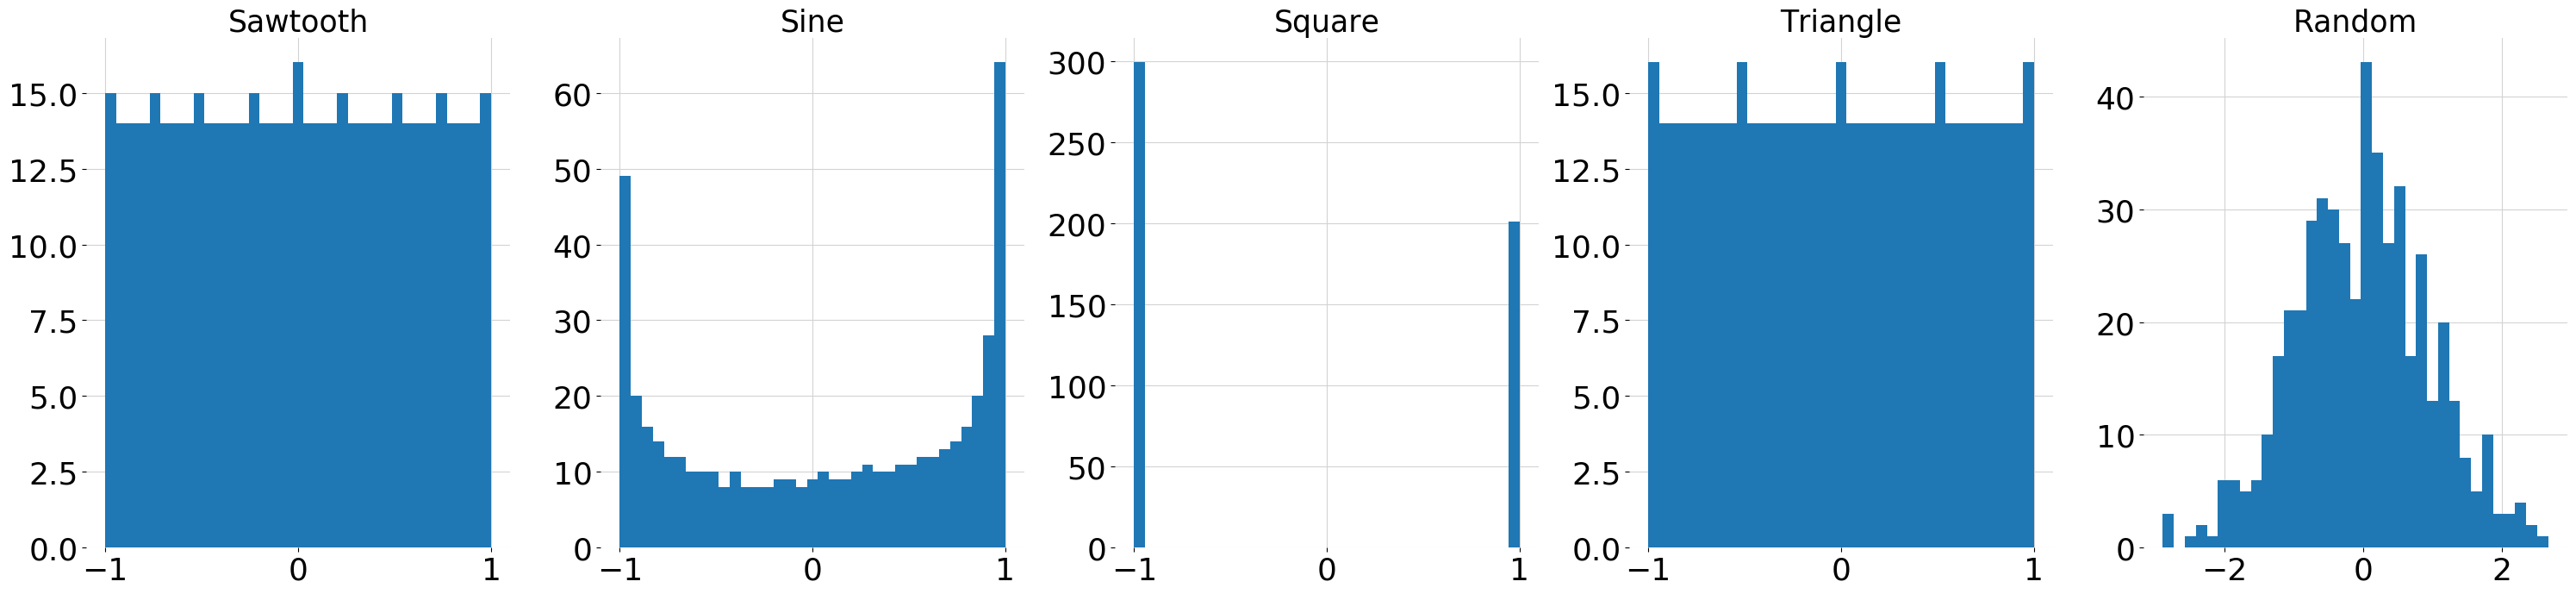

In [390]:
### 1.2 Histogram
# YOUR CODE HERE
def plot_histograms(X, data_type='Plots', bins=35, density=False, dpi=100):
    titles = ['Sawtooth', 'Sine', 'Square', 'Triangle', 'Random'] if data_type=='Sources' else ['Mix #1', 'Mix #2', 'Mix #3', 'Mix #4', 'Mix #5']
    fig, ax = plt.subplots(nrows=1, ncols=X.shape[0], figsize=(30, 7), dpi=dpi)
    for i in range(len(ax)):
        data = X[i, :]
        if density:
            count, bins, ignored = ax[i].hist(data, bins=bins, density=True)
            # plot a normal curve
            mu, sigma = np.mean(data), np.std(data)
            ax[i].plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
                       linewidth=2, linestyle='-', color="r")
        else:
            ax[i].hist(data, bins=bins)
        # Visual addings
        ax[i].set_title(titles[i], fontsize=25)
        ax[i].tick_params(axis='both', which='major', labelsize=26)
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        ax[i].spines["bottom"].set_visible(False)
        ax[i].grid(color='lightgrey', linestyle='-')
        ax[i].set_axisbelow(True)
        plt.tight_layout()

plot_histograms(X, data_type='X', density=False)
plot_histograms(S, data_type='Sources')

Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

$\small  \color{blue}{\textit{# YOUR ANSWER HERE}}$

$\textbf{i)}$ For the sources, we see that only the random on tend toward normal distributions. This is due to the Central Limit theorem (when independent random variables are added, their properly normalized sum tends toward a normal distribution). Moreover, we can argue that most of the mesurements tent to take a gaussian shape, as the histogram is produced by summing independent random variables.

$\textbf{ii)}$ Because the $x_i$ will just be weighted sums of the $s_i$:
$$ x_i = a_{i1}s_1 + a_{i2}s_2 + ... + a_{in}s_n$$
the central limit theorem says that the distribution of $x_i$ will be closer to Gaussian than the distribution of the $s_i$, which would make it impossible to recover the original sources. ICA is built on using the assumption of non-Gaussianality in the latent factors to tease them apart and the separation is based on deviation from normality. Thus, we can allow up to one source to follow a gaussian distribution.
 

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, *derive* the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

Give your answer without the normalizing constant, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

$\small  \color{blue}{\textit{# YOUR ANSWER HERE}}$


### $\textbf{0)}$ $\phi_0(a) = -\tanh(a)$
***
For the $tanx$, it is known that
$$
\tanh(x)=\frac{\sinh x}{\cosh x}=\frac{\left(e^{x}-e^{-x}\right) / 2}{\left(e^{x}+e^{-x}\right) / 2}
$$

Thus, we will have
$$
\int \tanh(a) \, dx = \int \frac{e^{a}-e^{-a}}{e^{a}+e^{-a}} d x
$$

Setting $\mathrm{u}=\mathrm{e}^{\mathrm{x}}+\mathrm{e}^{-\mathrm{x}}$, and, thus, $\mathrm{du}=\left(\mathrm{e}^{\mathrm{x}}-\mathrm{e}^{-\mathrm{x}}\right) \mathrm{dx}$ we will have

$$
\int \phi_0(a) \, dx 
= \int - \tanh(a) \, dx 
= -\int \frac{\mathrm{du}}{\mathrm{u}} \propto \ln |u| 
= -\ln \left(\mathrm{e}^{\mathrm{a}}+\mathrm{e}^{-\mathrm{a}}\right) 
\propto -\ln (\cosh a)
$$

Thus, we will have
$$
\phi_0(a) = \frac{d}{da} \ln p(a) 
\iff  \int -\tanh(a) = \int \frac{d}{da} \ln p(a) 
\iff  -\ln (\cosh a) =  \ln p(a)
\iff  p(a) =  \cosh^{-1} (a)
$$

### $\textbf{1)}$ $\phi_1(a) = -a + \tanh(a)$
***

Since
$$\int \phi_1(a) da = - \int a \, da + \int \tanh(a) \, da = -\frac{1}{2}a^2 + \ln (\cosh a)
$$


Thus, we will have
$$
\phi_1(a) \propto e^{-\frac{1}{2}a^2} \cdot \cosh (a)
$$


### $\textbf{2)}$ $\phi_{2}(a) = -a^3$
***

$$\int \phi(a) da = - \int a^3 \ da = -\frac{1}{4} a^4 + c$$

Thus:

$$p(a) \propto e^{-\frac{1}{4}a^4}$$

### $\textbf{3)}$ $\phi_3(a) = -\frac{6a}{a^2 + 5}$
***

$$ \int \phi_3(a) \, da = \int -\frac{6a}{a^2 + 5} \, da = -3 \int \frac{2a}{a^2 + 5} \, da
= -3 \ln|{a^2 + 5}| + C \propto -3 \ln(a^2 + 5) = \ln(a^2 + 5)^{-3}
$$

Thus
$$ p(a) \propto  e^{\ln (a^2 + 5)^{-3}} \quad \text{or} \quad  p(a) \propto  (a^2 + 5)^{-3}$$

In [391]:
def phi_0(a):
    return -np.tanh(a)

def p_0(a):
    # YOUR CODE HERE
    return (np.cosh(a))**(-1)

In [392]:
def phi_1(a):
    return -a + np.tanh(a)

def p_1(a):
    # YOUR CODE HERE
    return np.exp(-a**(2)/2) * np.cosh(a)

In [393]:
def phi_2(a):
    return -a**3

def p_2(a):
    # YOUR CODE HERE
    return np.exp(-a**(4)/4)

In [394]:
def phi_3(a):
    return -6*a / (a**2 + 5)

def p_3(a):
    # YOUR CODE HERE
    return (a**2+5)**(-3)

In [395]:
activation_functions = [phi_0, phi_1, phi_2, phi_3]
priors = [p_0, p_1, p_2, p_3]

a = np.linspace(-5, 5, 1000)
for prior in priors:
    assert prior(a).shape == (1000, ), "Wrong output shape"


Plot the activation functions and the corresponding prior distributions, from $a = -5$ to $5$ (hint: use the lists defined in the cell above). Compare the shape of the priors to the histogram you plotted in the last question.

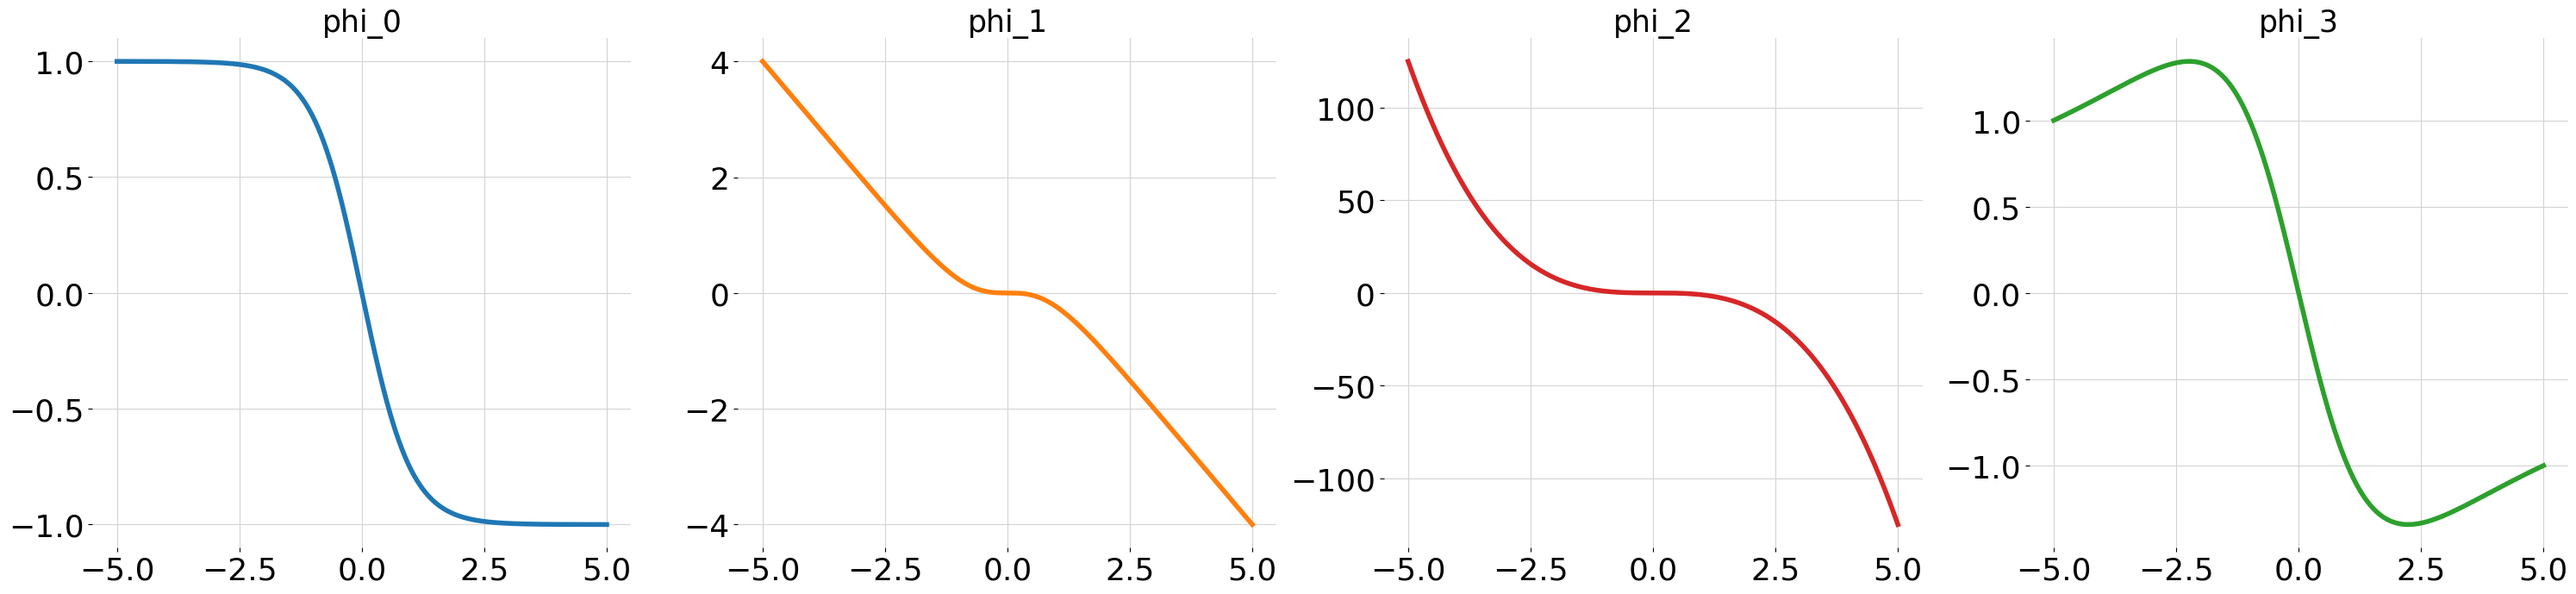

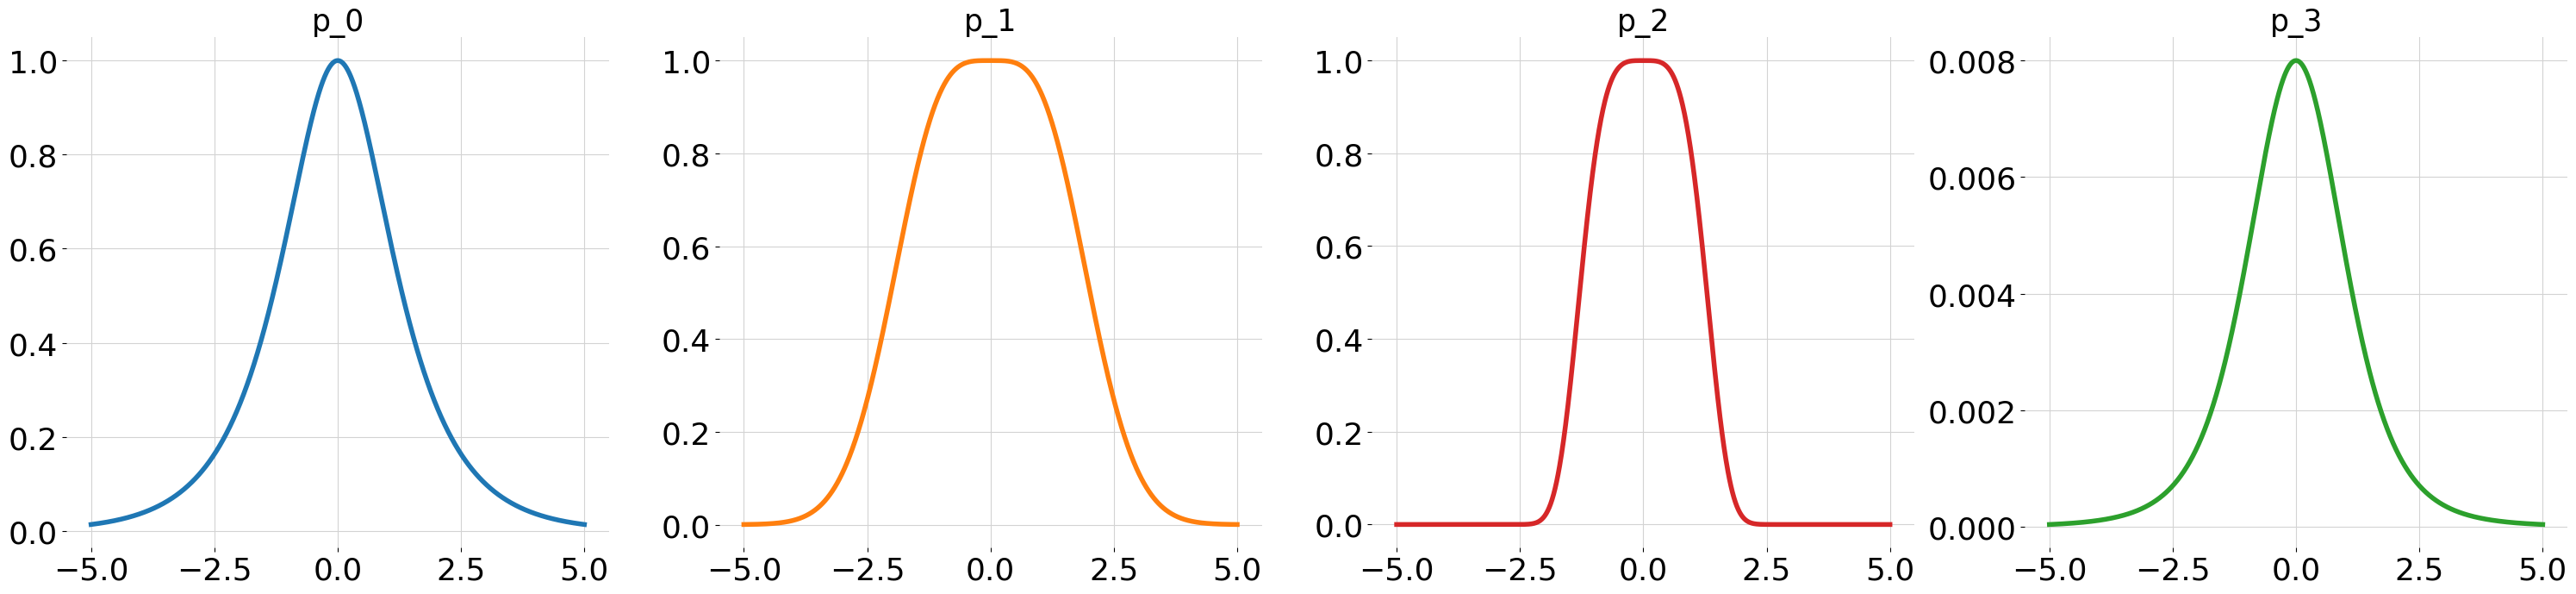

In [396]:
### 1.3 Implicit priors (continued)
a = np.linspace(-5, 5, 1000)

# YOUR CODE HERE
def plot_pdfs(pdfs_list, x):
    fig, ax = plt.subplots(nrows=1, ncols=len(pdfs_list), figsize=(30, 7), dpi=100)
    colors = ["#1f77b4", "#ff7f0e", "#d62728", "#2ca02c"]

    for i in range(len(pdfs_list)):
        pdf = pdfs_list[i]
        ax[i].plot(x, pdf(x), color=colors[i], linewidth=4)
        # Visual addings
        ax[i].set_title(str(pdf.__name__), fontsize=25)
        ax[i].tick_params(axis='both', which='major', labelsize=26)
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        ax[i].spines["bottom"].set_visible(False)
        ax[i].grid(color='lightgrey', linestyle='-')
        ax[i].set_axisbelow(True)
        plt.tight_layout()

plot_pdfs(activation_functions, a)
plot_pdfs(priors, a)

$\small  \color{blue}{\textit{# YOUR ANSWER HERE}}$

#### Comparison 

Even though the histograms did not followed a gaussian trend, now we see that the shape of the priors do ($p_0$ and $p_3$ seemed to have more the natural "bell curve" than the other two, which are more flattent at their mean/ max). 

For the Sine Triangle and Random, our prior is close to their histogram, while for sawtooth and square, which are binomial, it poorer desition to go with a unimodal prior like the Gaussian.

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf. Your function should also center the data before whitening.

In [480]:
### 1.4 Whitening
def whiten(X):
    # YOUR CODE HERE
    Sigma = np.cov(X)
    # Center the rows of the data
    mean = A.mean(axis=1)
    X = X - mean[:, None]
    # Eigenvalue Decomposition
    L, F = np.linalg.eig(Sigma)
    return np.diag(np.power(L, -0.5)) @ (F.T @ X)

In [481]:
### Test your function
Xw = whiten(X)
assert Xw.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.5 Interpret results of whitening (10 points)
Make 3 figures, one for the sources, one for measurements and one for the whitened measurements. In each figure, make $5 \times 5$ subplots with scatter plots for each pair of signals. Each axis represents a signal and each time-instance is plotted as a dot in this space. You can use the `plt.scatter()` function. Describe what you see.

Now compute and visualize the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize each covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

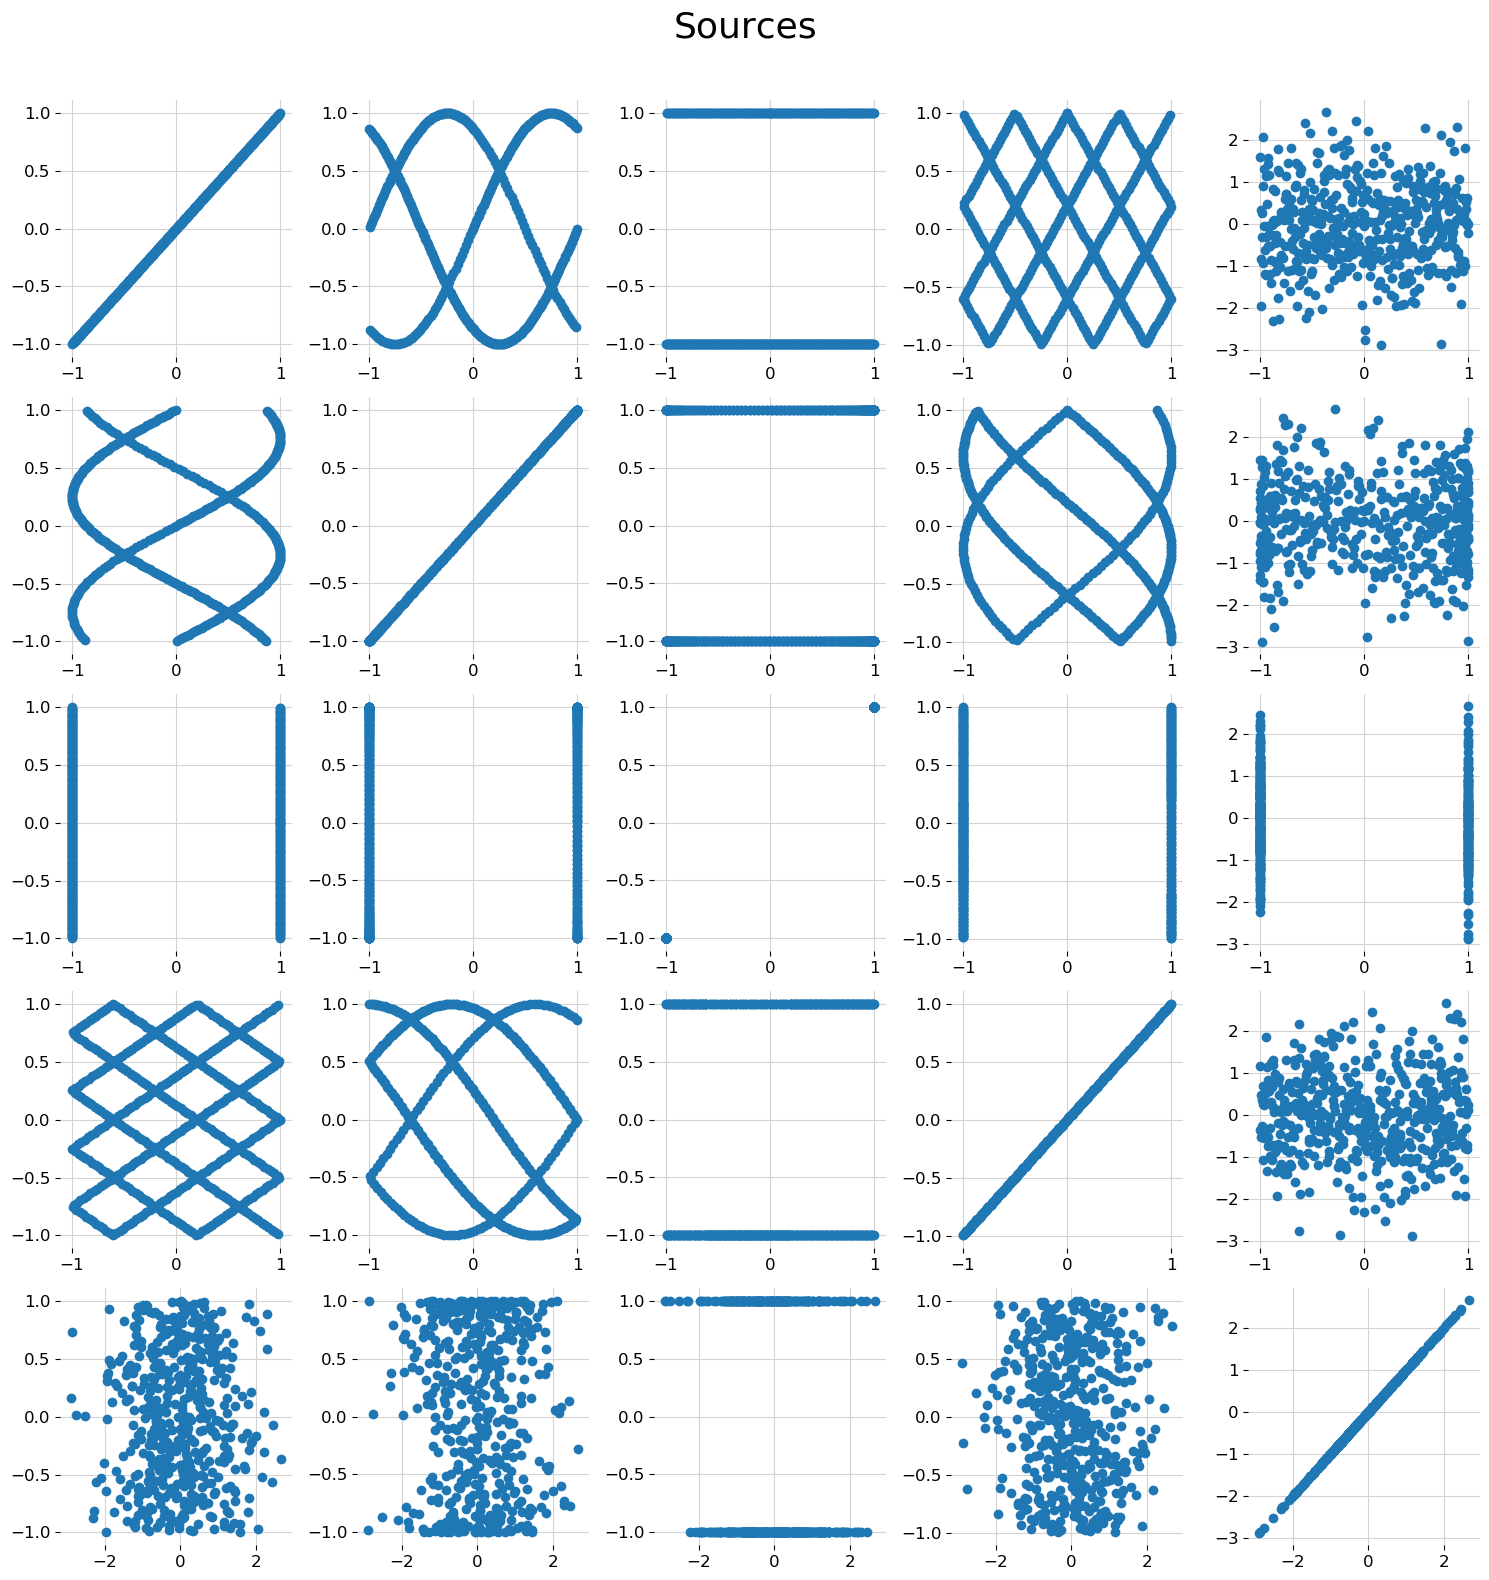

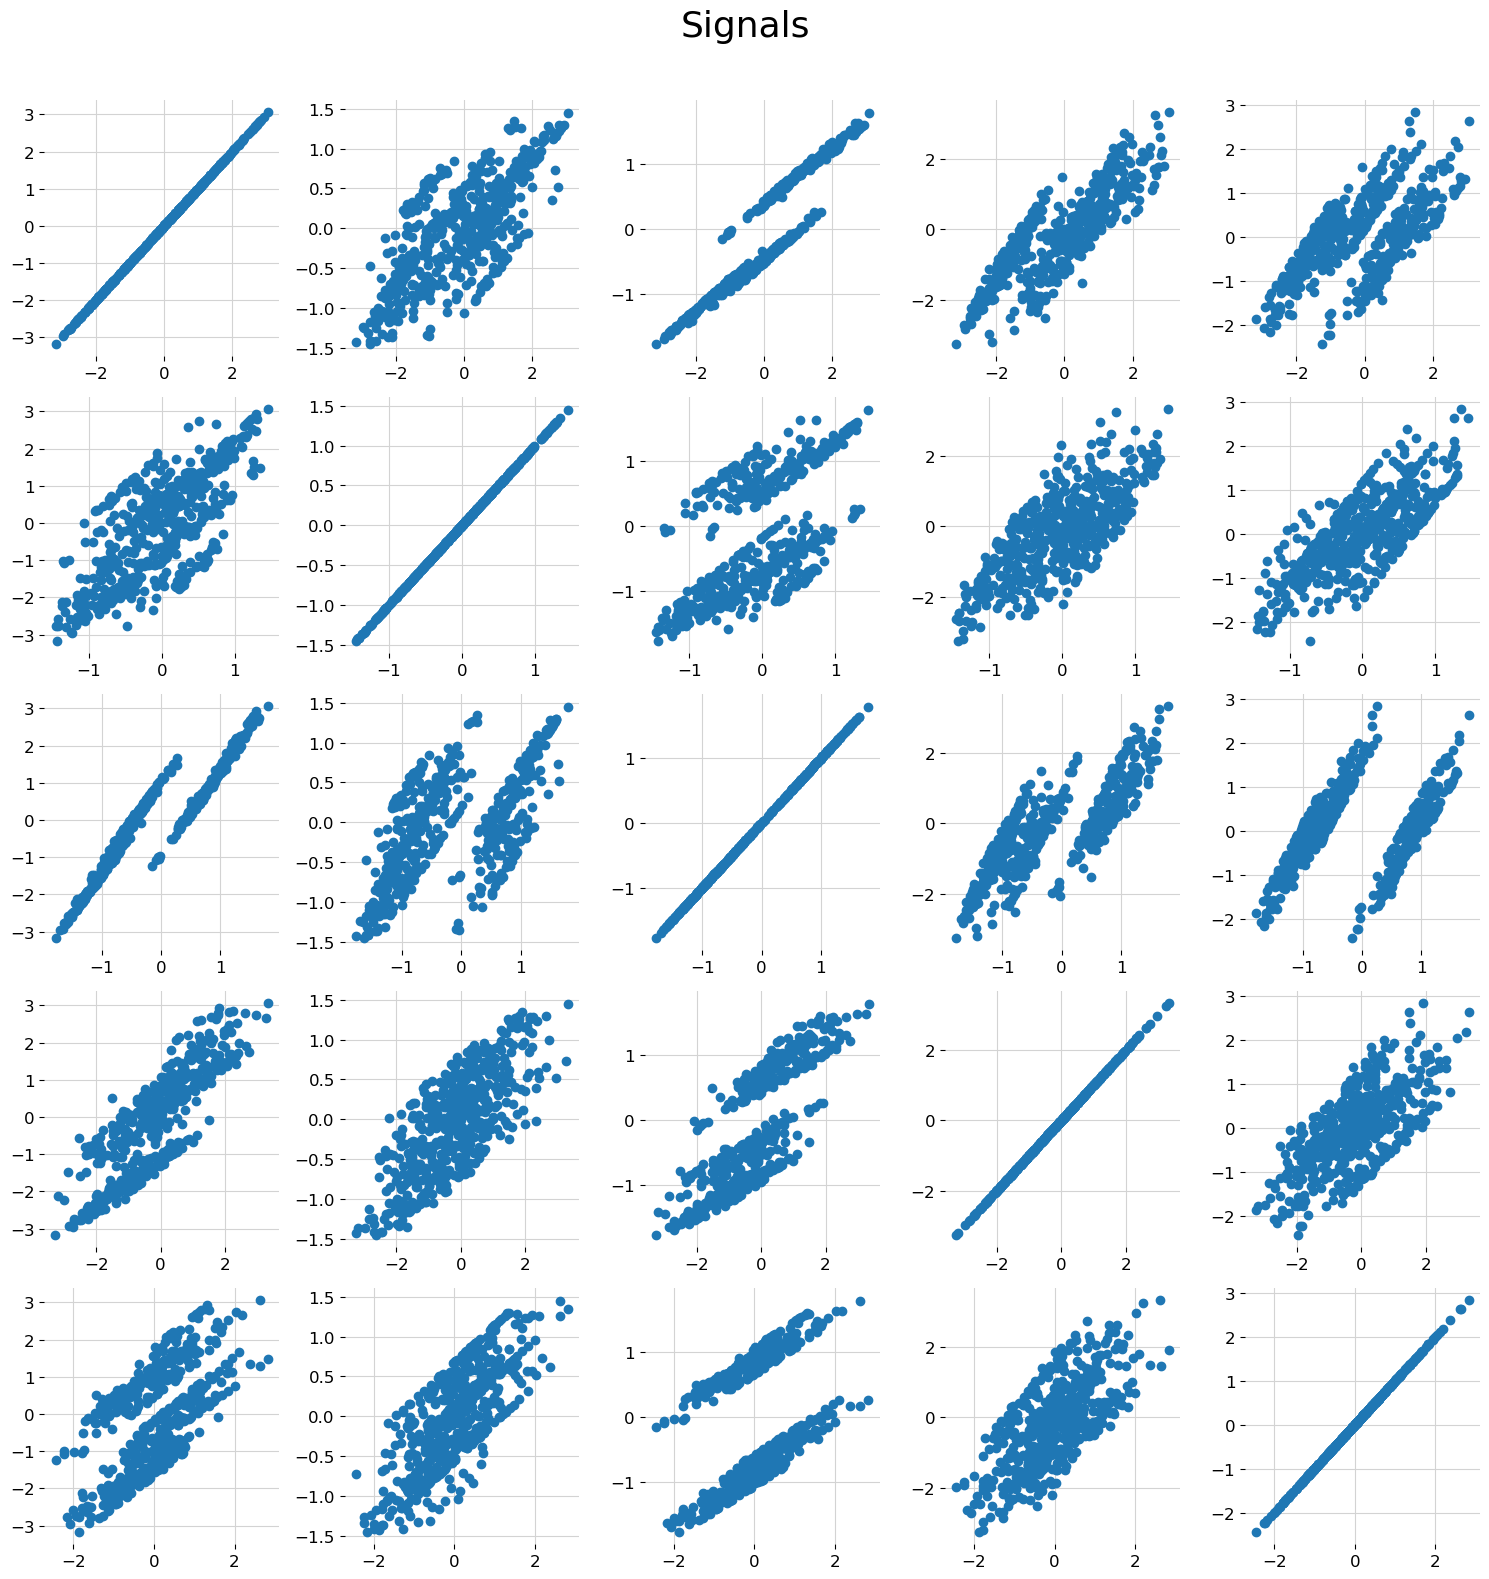

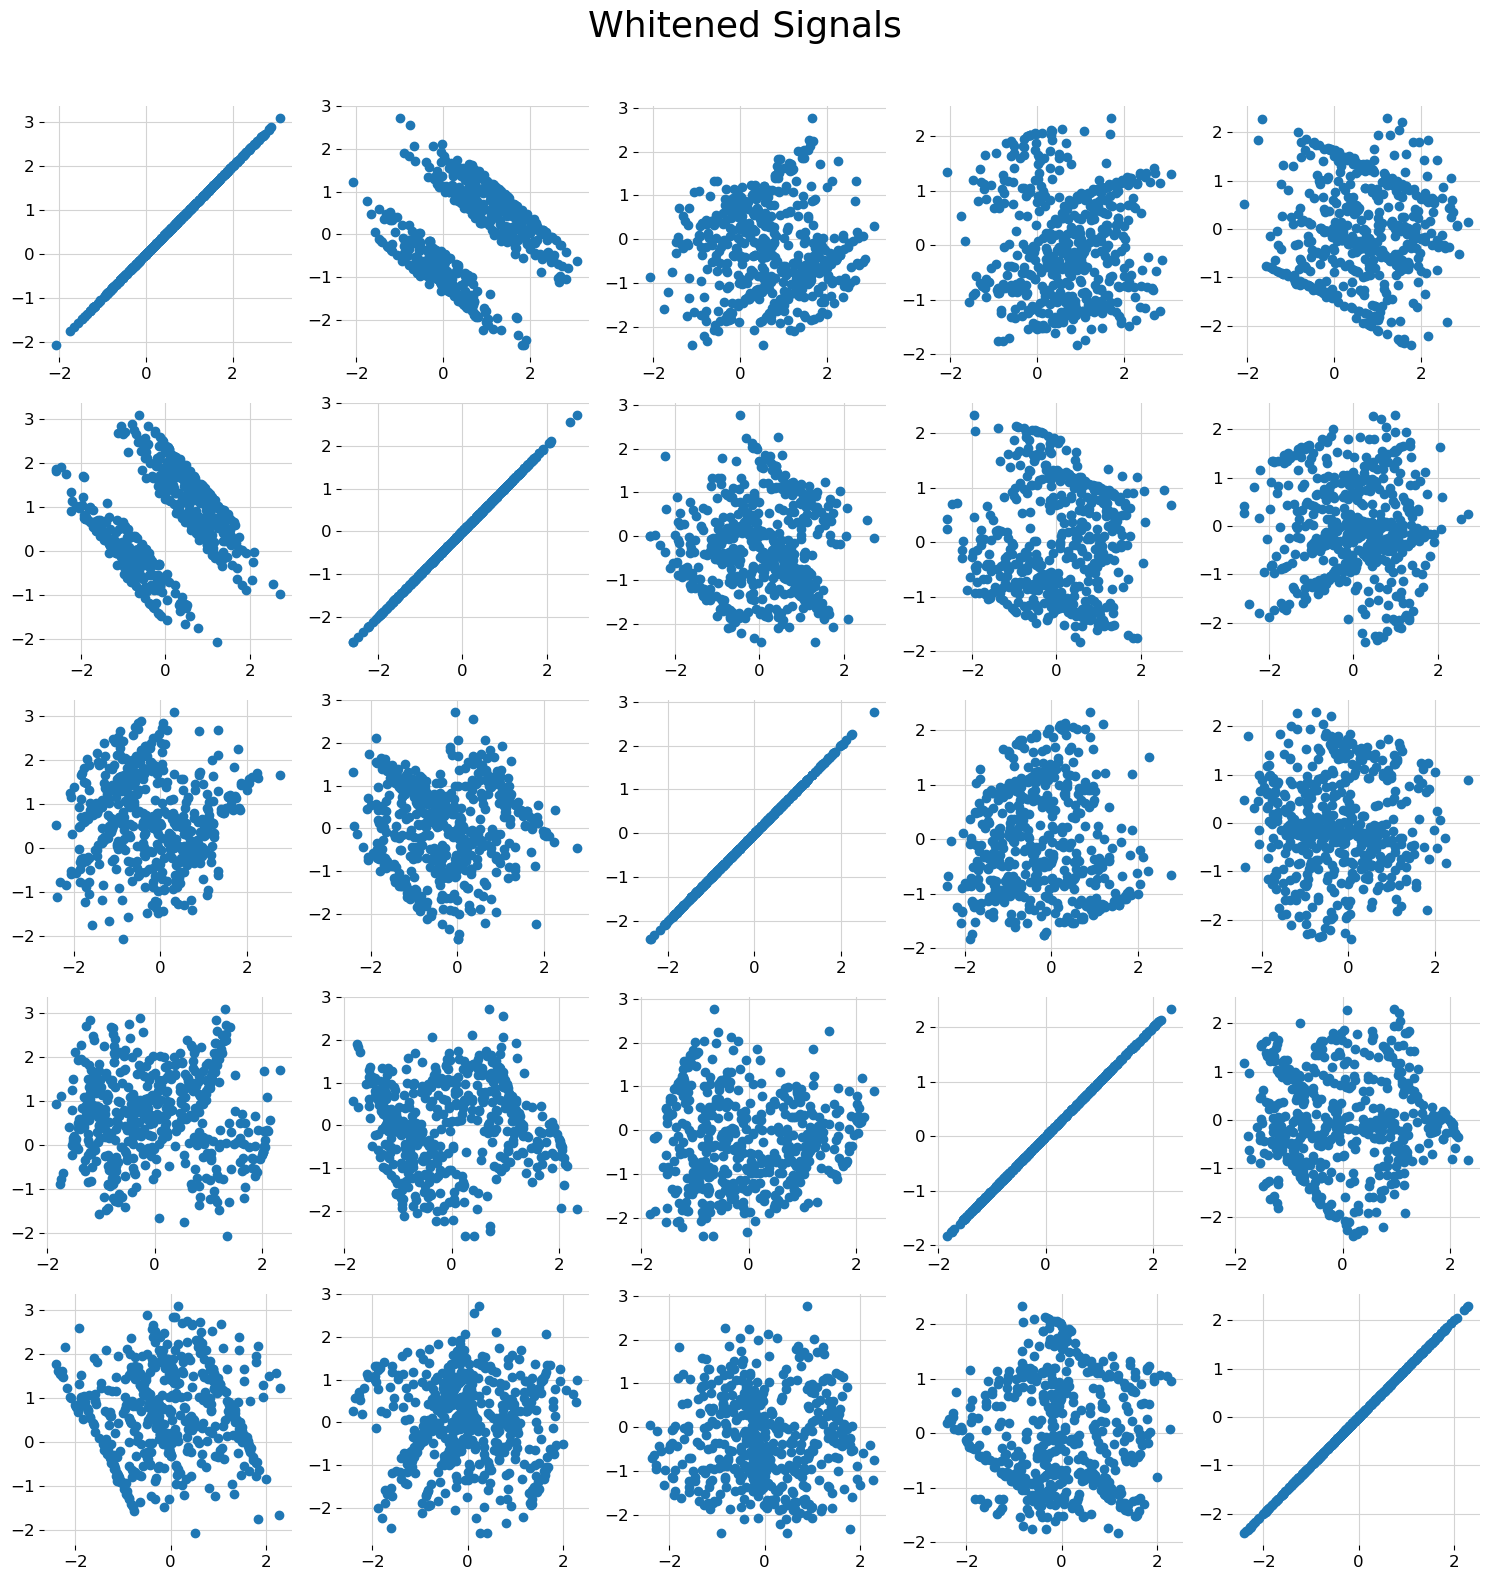

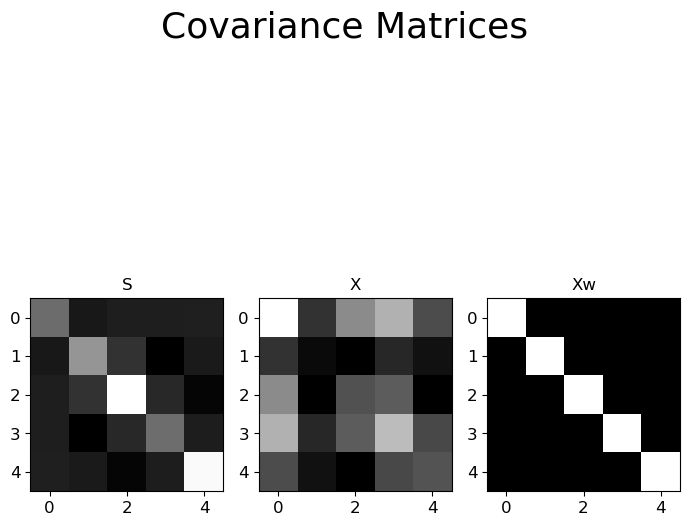

In [482]:
### 1.5 Interpret results of whitening\
# YOUR CODE HERE
def plot_scatter(X, title='Data scatter plots'):
    fig, ax = plt.subplots(nrows=X.shape[0], ncols=X.shape[0], figsize=(15, 15), dpi=100)
    k=0
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            ax[i][j].scatter(X[i,:], X[j,:])
            # Visualization options
            ax[i][j].tick_params(axis='both', which='major', labelsize=12)
            ax[i][j].spines["top"].set_visible(False)
            ax[i][j].spines["right"].set_visible(False)
            ax[i][j].spines["left"].set_visible(False)
            ax[i][j].spines["bottom"].set_visible(False)
            ax[i][j].grid(color='lightgrey', linestyle='-')
            ax[i][j].set_axisbelow(True)
            plt.tight_layout()

    fig.suptitle(title, y=1.05, fontsize=26)

def plot_cov(data, titles):
    fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(7, 7), dpi=100)
    for i in range(len(data)):
        ax[i].imshow(np.cov(data[i]), cmap='gray', interpolation='nearest')
        ax[i].set_title(titles[i])
        ax[i].tick_params(axis='both', which='major', labelsize=12)
        plt.tight_layout()
    
    fig.suptitle('Covariance Matrices', y=1.0, fontsize=26)


# Plot scatter
plot_scatter(S, title='Sources')
plot_scatter(X, title='Signals')
plot_scatter(Xw, title='Whitened Signals')

# Plot cov matrices
plot_cov([S, X, Xw], titles=['S', 'X', 'Xw'])


Are the signals independent after whitening?

$\small  \color{blue}{\textit{# YOUR ANSWER HERE}}$

Yes, this can be verified by looking at the covariance matrices (only the diagonal is total white, which mean there is no correlation with the other signals) and from the scallar plot, we can see that for the sources and the signals there is a pattent between the data, on the whiteing ones having the result of one, you can not tell anything about the other (indipendent).

### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

$\small  \color{blue}{\textit{# YOUR ANSWER HERE}}$



### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Make it efficient, so use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code). Experiment with the learning rate and the initialization of $\mathbf{W}$. Your algorithm should be able to converge (i.e. `np.linalg.norm(grad) < 1e-5`) in within 10000 steps.

In [ ]:
### 1.7 Independent Component Analysis
def ICA(X, activation_function, learning_rate=0.1):
    # YOUR CODE HERE
    raise NotImplementedError()

W_est = ICA(Xw, phi_3, learning_rate=0.5)  # Compare with ICA(X)

In [ ]:
# We will test your function so make sure it runs with only X and phi as input, and returns only W
# Also it should converge for all activation functions

W_estimates = [ICA(Xw, activation_function=phi, learning_rate=1.0) for phi in activation_functions]
assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])


### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$ (or reuse `W_estimates`). Use the found demixing matrix $\mathbf{W}$ to reconstruct the signals and plot the retreived signals for each choice of activation function.

In [ ]:
# 1.8 Experiments
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
def does_whitening_make_a_difference():
    # Does it make a difference (in terms of speed of convergence) 
    # if you whiten your data before running ICA?
    
    # Return True or False
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert type(does_whitening_make_a_difference()) == bool

### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files. You can listen to the results in your browser using `play_signals`, or save them to disk if this does not work for you. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [ ]:
import scipy.io.wavfile
from IPython.display import Audio, display, Markdown

# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

# Or play them in your browser
def play_signals(S, sample_rate, title="Signals"):
    display(Markdown(title))
    for signal in S:
        display(Audio(signal, rate=sample_rate))

In [ ]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)
play_signals(S_audio, sample_rate)

In [ ]:
### 1.9 Audio demixing
# YOUR CODE HERE
raise NotImplementedError()

Report your results. Using which activation functions ICA recovers the sources?

YOUR ANSWER HERE

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. You may find it helpful to use an online service such as [Wolfram Alpha](https://www.wolframalpha.com/) or [Integral Calculator](https://www.integral-calculator.com/) to (help you) evaluate the required integrals. Give your answer as both an exact expression as well as a numerical approximation (for example $\frac{\pi}{2} \approx 1.571$).

YOUR ANSWER HERE

In [ ]:
### Include your answer here (you can use math.gamma if needed)
def get_kurtosis():
    # Return a list with 4 numbers / expressions
    # return [0, 0, 0, 0]
    
    # YOUR CODE HERE
    raise NotImplementedError()
    

In [ ]:
# Let's check
kurtosis = get_kurtosis()
print (kurtosis)
assert len(kurtosis) == 4


#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

Can you use this data to explain the performance of the various activation functions on the synthetic and real data?

In [ ]:
### 1.10.2 Excess Kurtosis
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE